In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('/content/merged_hourly_load_weather.csv')

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [4]:
df.head()

,load,temperature_2m,relative_humidity_2m,precipitation,windspeed_10m,winddirection_10m,cloudcover,pressure_msl,dew_point_2m
datetime,,,,,,,,,
2018-01-01 00:00:00,1742.110000,11.8,76,0.0,3.7,281,0,1014.5,7.7
2018-01-01 01:00:00,1568.937500,9.0,86,0.0,4.8,257,0,1014.5,6.8
2018-01-01 02:00:00,1468.707500,8.1,87,0.0,6.5,264,0,1013.8,6.1
2018-01-01 03:00:00,1424.403333,7.9,87,0.0,7.9,267,0,1013.4,5.9
2018-01-01 04:00:00,1471.805000,8.1,85,0.0,6.1,273,0,1013.3,5.8


In [5]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df["day_of_month"] = df.index.day
df["day_of_year"] = df.index.day_of_year
df["year"] = df.index.year
df["week_of_year"] = df.index.isocalendar().week.astype("int64")
df.head()

,load,temperature_2m,relative_humidity_2m,precipitation,windspeed_10m,winddirection_10m,cloudcover,pressure_msl,dew_point_2m,hour,dayofweek,month,day_of_month,day_of_year,year,week_of_year
datetime,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1742.110000,11.8,76,0.0,3.7,281,0,1014.5,7.7,0,0,1,1,1,2018,1
2018-01-01 01:00:00,1568.937500,9.0,86,0.0,4.8,257,0,1014.5,6.8,1,0,1,1,1,2018,1
2018-01-01 02:00:00,1468.707500,8.1,87,0.0,6.5,264,0,1013.8,6.1,2,0,1,1,1,2018,1
2018-01-01 03:00:00,1424.403333,7.9,87,0.0,7.9,267,0,1013.4,5.9,3,0,1,1,1,2018,1
2018-01-01 04:00:00,1471.805000,8.1,85,0.0,6.1,273,0,1013.3,5.8,4,0,1,1,1,2018,1


In [6]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 827.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 154.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 138.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 22.4 MB/s eta 0:00:00


In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [8]:
threshold_date_1 = "01-01-2024"
threshold_date_2 = "01-01-2025"

In [9]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

In [10]:
# Load the pre-trained model from the central server
global_model = load_model("/content/deeplstm (1).keras")

In [11]:
FEATURES = ["hour", "day_of_month", "dayofweek", "day_of_year", "month", "year", "week_of_year", "temperature_2m", "relative_humidity_2m",	"windspeed_10m", "dew_point_2m"]
TARGET = "load"
FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = test_data[FEATURES_TARGET]
test_data_keras = hold_out_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = train_data_keras_s[:, :-1].reshape(train_data_keras_s.shape[0], 1, len(FEATURES))
y_train_keras = train_data_keras_s[:, -1]
X_test_keras = test_data_keras_s[:, :-1].reshape(test_data_keras_s.shape[0], 1, len(FEATURES))
y_test_keras = test_data_keras_s[:, -1]

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

def create_lstm_model(input_shape):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=256, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))

    # Second LSTM layer
    model.add(LSTM(units=128, activation='tanh', return_sequences=True))
    model.add(Dropout(0.5))

    # Third LSTM layer
    model.add(LSTM(units=32, activation='tanh', return_sequences=False))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(units=1))  # For regression

    model.compile(optimizer='adam', loss='mae')
    return model

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, mode='min')
model_checkpoint = ModelCheckpoint('fed_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=0,
    mode='min'
)

In [14]:
def split_data_among_clients(X, y, num_clients):
    split_size = len(X) // num_clients
    client_data = []
    for i in range(num_clients):
        start = i * split_size
        end = (i+1) * split_size if i != num_clients-1 else len(X)
        client_data.append((X[start:end], y[start:end]))
    return client_data

In [15]:
def aggregate_weights(weights_list):
    avg_weights = []
    for weights in zip(*weights_list):
        avg_weights.append(np.mean(weights, axis=0))
    return avg_weights

In [16]:
num_clients = 1
client_data = split_data_among_clients(X_train_keras, y_train_keras, num_clients)

num_rounds = 2 # Number of federated rounds
global_weights = global_model.get_weights()

In [17]:
epochs = 50
Input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])
def federated_finetune(client_data, global_model):
    client_weights = []

    for client_idx in range(num_clients):
        # Create a local model based on the pre-trained global model
        local_model = tf.keras.models.clone_model(global_model)
        local_model.set_weights(global_model.get_weights())  # Load global model weights

        # Fine-tune the local model on the client's local data
        X_client, y_client = client_data[client_idx]
        # Compile the model
        local_model=create_lstm_model(Input_shape)
        local_model.fit(X_client, y_client, epochs=epochs, batch_size=32, validation_data=(X_test_keras, y_test_keras), callbacks=[early_stopping, model_checkpoint, reduce_lr_loss])

        # Collect the fine-tuned weights for aggregation
        client_weights.append(local_model.get_weights())

    return client_weights

In [18]:
def update_global_model(client_weights, global_model):
    # Aggregate client weights to update the global model incrementally
    global_weights = global_model.get_weights()

    global_model.set_weights(client_weights[0])

    return global_model

In [19]:
for round_num in range(num_rounds):
    print(f"Federated Learning Round {round_num + 1}/{num_rounds}")

    # Fine-tune locally on each client and update global model
    client_weights = federated_finetune(client_data, global_model)

    # Update the global model with the fine-tuned weights
    global_model = update_global_model(client_weights, global_model)

Federated Learning Round 1/2
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1984 - val_loss: 0.1112 - learning_rate: 0.0010
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1168 - val_loss: 0.1137 - learning_rate: 0.0010
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1106 - val_loss: 0.1239 - learning_rate: 0.0010
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1062 - val_loss: 0.1277 - learning_rate: 0.0010
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1033 - val_loss: 0.1256 - learning_rate: 0.0010
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0996 - val_loss: 0.1280 - learning_rate: 0.0010
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0973 - val_loss: 0.1171 - learning_rate: 1.0000e-04
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0962 - val_loss: 0.1156 - learning_rate: 1.0000e-04
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0964 - val_loss: 0.1155 - learning_rate: 1.0000e-04
Federated

In [20]:
# 1. Predict using the initial (global) model
pred_lstm = global_model.predict(X_test_keras)

# 2. Prepare results for inverse scaling
results_lstm = test_data_keras_s.copy()
results_lstm[:, -1] = pred_lstm.reshape(-1)  # Replace the target column with predictions

# 3. Inverse transform
results_lstm_unscaled = scaler.inverse_transform(results_lstm)

# 4. Create result dataframe
result_frame_lstm = pd.DataFrame(index=hold_out_data.index)  # Use test_data's index
result_frame_lstm["actual_load"] = hold_out_data["load"].values
result_frame_lstm["predicted_load"] = results_lstm_unscaled[:, -1]

# 5. Calculate Metrics
mape_lstm = np.mean(np.abs((result_frame_lstm["actual_load"] - result_frame_lstm["predicted_load"]) / result_frame_lstm["actual_load"])) * 100
rmse_lstm = np.sqrt(np.mean(np.square(result_frame_lstm["actual_load"] - result_frame_lstm["predicted_load"])))

# 6. Print Metrics
print(f"MAPE of Fed Model: {mape_lstm:.2f}%")
print(f"RMSE of Fed Model: {rmse_lstm:.2f} MW")

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MAPE of Fed Model: 8.08%
RMSE of Fed Model: 311.30 MW


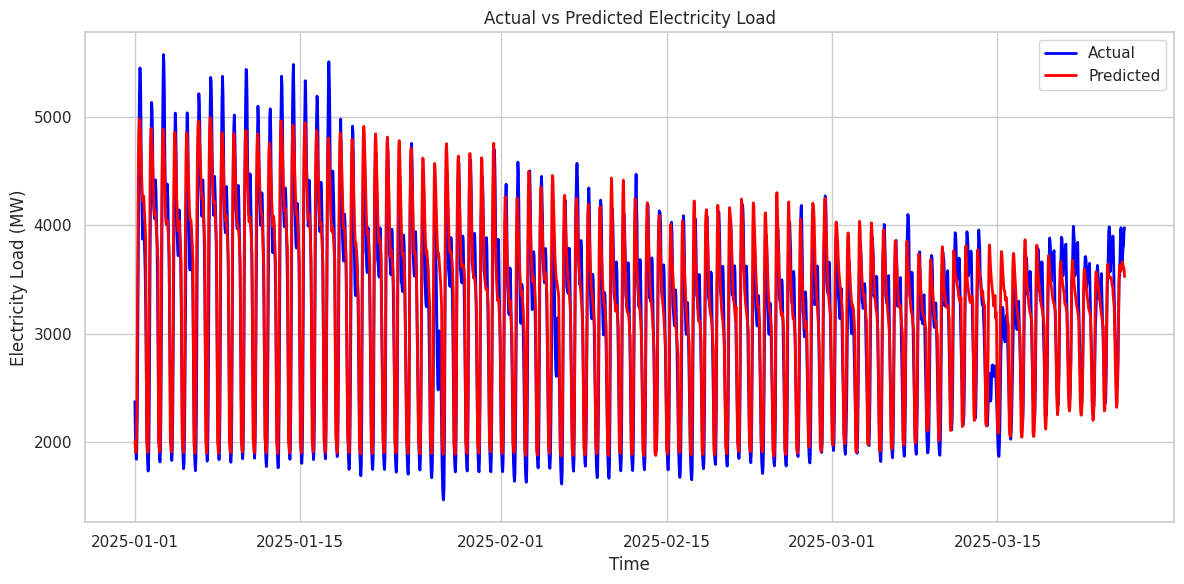

In [23]:
import seaborn as sns
from matplotlib import rcParams  # Import rcParams
import matplotlib.pyplot as plt
# Set general plot aesthetics
sns.set(style="whitegrid")
rcParams['figure.figsize'] = 15, 6

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Actual vs Predicted using seaborn styling
ax.plot(result_frame_lstm.index, result_frame_lstm['actual_load'], label='Actual', color='blue', linewidth=2)
ax.plot(result_frame_lstm.index, result_frame_lstm['predicted_load'], label='Predicted', color='red', linewidth=2)

# Customize axes
ax.set_xlabel("Time")
ax.set_ylabel("Electricity Load (MW)")
ax.set_title("Actual vs Predicted Electricity Load")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [24]:
global_model.save('federated.keras')

In [25]:
FEATURES = ["hour", "day_of_month", "dayofweek", "day_of_year", "month", "year", "week_of_year", "temperature_2m", "relative_humidity_2m",	"windspeed_10m", "dew_point_2m"]
TARGET = "load"
FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = train_data_keras_s[:, :-1].reshape(train_data_keras_s.shape[0], 1, len(FEATURES))
y_train_keras = train_data_keras_s[:, -1]
X_test_keras = test_data_keras_s[:, :-1].reshape(test_data_keras_s.shape[0], 1, len(FEATURES))
y_test_keras = test_data_keras_s[:, -1]

In [26]:
# Load the pre-trained model from the central server
globe = load_model("/content/deeplstm (1).keras")

In [27]:
# 1. Predict using the initial (global) model
pred_lstm = globe.predict(X_test_keras)

# 2. Prepare results for inverse scaling
results_lstm = test_data_keras_s.copy()
results_lstm[:, -1] = pred_lstm.reshape(-1)  # Replace the target column with predictions

# 3. Inverse transform
results_lstm_unscaled = scaler.inverse_transform(results_lstm)

# 4. Create result dataframe
result_frame_lstm = pd.DataFrame(index=test_data.index)  # Use test_data's index
result_frame_lstm["actual_load"] = test_data["load"].values
result_frame_lstm["predicted_load"] = results_lstm_unscaled[:, -1]

# 5. Calculate Metrics
mape_lstm = np.mean(np.abs((result_frame_lstm["actual_load"] - result_frame_lstm["predicted_load"]) / result_frame_lstm["actual_load"])) * 100
rmse_lstm = np.sqrt(np.mean(np.square(result_frame_lstm["actual_load"] - result_frame_lstm["predicted_load"])))

# 6. Print Metrics
print(f"MAPE of Fed Model: {mape_lstm:.2f}%")
print(f"RMSE of Fed Model: {rmse_lstm:.2f} MW")

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAPE of Fed Model: 8.47%
RMSE of Fed Model: 470.76 MW


In [28]:
result_frame_lstm.index = pd.to_datetime(result_frame_lstm.index)
last_date = result_frame_lstm.index[-1]

day_data = result_frame_lstm.loc['2024-05-01':'2024-05-01 23:59:59']
week_data = result_frame_lstm.loc[pd.to_datetime("2024-05-01"):pd.to_datetime("2024-05-07")]
month_data = result_frame_lstm.loc[pd.to_datetime("2024-12-01"):pd.to_datetime("2024-12-31")]

In [29]:
def plot_forecast(df, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['actual_load'], label='Actual', color='blue', linewidth=2)
    ax.plot(df.index, df['predicted_load'], label='Predicted', color='red', linewidth=2)
    ax.set_xlabel("Time")
    ax.set_ylabel("Electricity Load (MW)")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


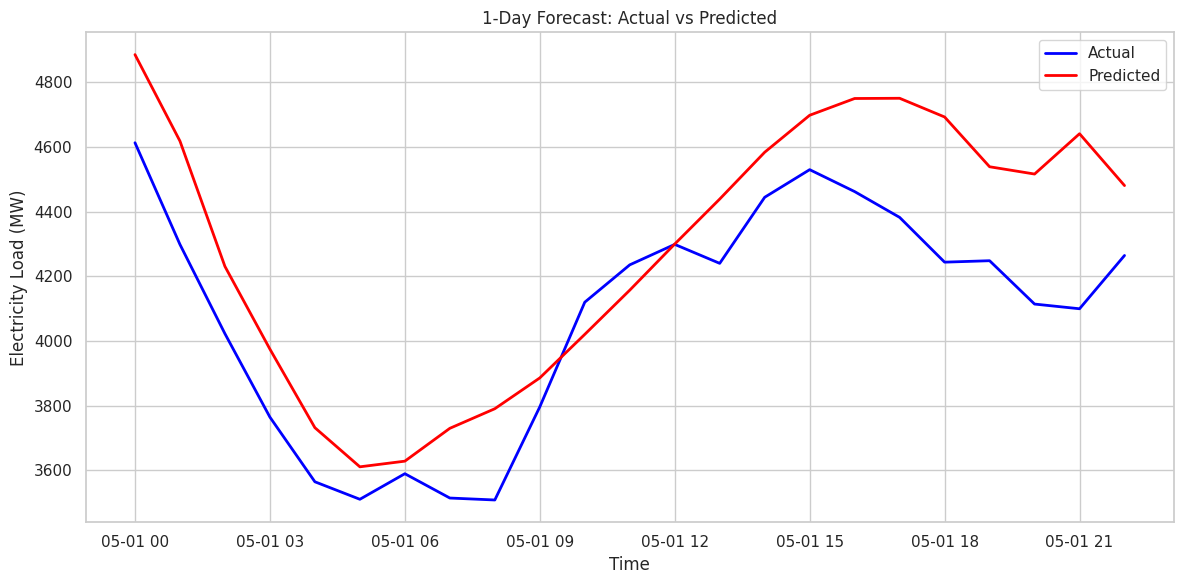

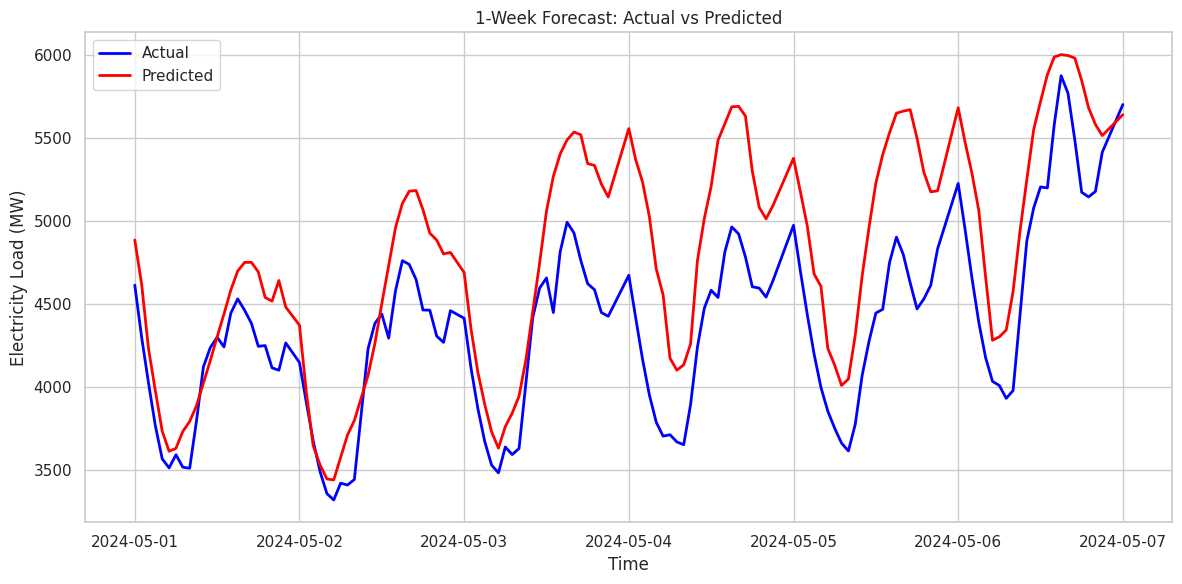

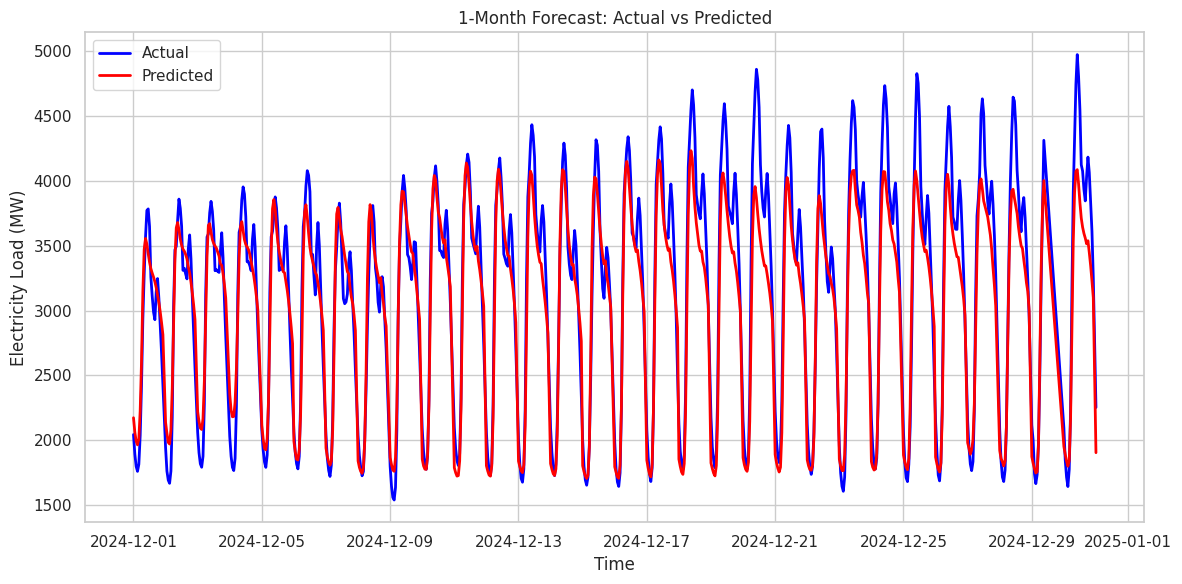

In [30]:
plot_forecast(day_data, "1-Day Forecast: Actual vs Predicted")
plot_forecast(week_data, "1-Week Forecast: Actual vs Predicted")
plot_forecast(month_data, "1-Month Forecast: Actual vs Predicted")